### Metrics calculation and some plots
Use this notebook to calculate the Dice scores for the images the network was not trained on. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [1]:
unet_exps =  '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/UNet/UNet_VxM'
vxm_exps =   '/home/aranem_locale/Desktop/mnts/local/scratch/aranem/MICCAI_2023/MICCAI_2023_predictions/VoxelMorph/VoxelMorph_rigid'

#### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pystrum, copy
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable

os.environ['NEURITE_BACKEND'] = "pytorch"
import neurite as ne

/home/aranem_locale/anaconda3/envs/Lifelong-nnUNet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Helpful functions and other stuffs

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def mean_dice_coef(y_true, y_pred_bin, num_classes=1, do_torch=False):
    # from: https://www.codegrepper.com/code-examples/python/dice+similarity+coefficient+python
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    depth = y_true.shape[-1]
    # channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    # dict contains label: dice per batch
    channel_dices_per_batch = {i+1:list() for i in range(num_classes)}
    for i in range(batch_size):
        # for n in range(depth):
        for j in range(1, num_classes+1):
            y_t = y_true[i, ...].clone() if do_torch else copy.deepcopy(y_true[i, ...])
            y_p = y_pred_bin[i, ...].clone() if do_torch else copy.deepcopy(y_pred_bin[i, ...])
            y_t[y_t != j] = 0
            y_t[y_t == j] = 1
            y_p[y_p != j] = 0
            y_p[y_p == j] = 1
            channel_dice = single_dice_coef(y_t, y_p, do_torch)
            channel_dices_per_batch[j].append(channel_dice)
            # channel_dice = single_dice_coef(y_true[i, :, :, j], y_pred_bin[i, :, :, j], num_classes, do_torch)
            mean_dice_channel += channel_dice/(num_classes*batch_size)
    return mean_dice_channel, channel_dices_per_batch

def single_dice_coef(y_true, y_pred_bin, do_torch=False):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin) if not do_torch else torch.sum(y_true * y_pred_bin)
    if do_torch:
        if (torch.sum(y_true)==0) and (torch.sum(y_pred_bin)==0):
            return 1
        return ((2*intersection) / (torch.sum(y_true) + torch.sum(y_pred_bin))).item()
    else:
        if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
            return 1
        return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)
    
val_keys = {'Task110_RUNMC': ['Case03', 'Case08', 'Case12', 'Case15', 'Case18', 'Case26'],
            'Task111_BMC': ['Case03', 'Case08', 'Case12', 'Case15', 'Case18', 'Case26'],
            'Task112_I2CVB': ['Case03', 'Case08', 'Case13', 'Case15'],
            'Task113_UCL': ['Case01', 'Case32', 'Case34'],
            'Task114_BIDMC': ['Case00', 'Case04', 'Case09'],
            'Task115_HK': ['Case38', 'Case41', 'Case46'],
            'Task116_DecathProst': ['prostate_00', 'prostate_04', 'prostate_14', 'prostate_20', 'prostate_25', 'prostate_31', 'prostate_42']}

### VoxelMorph results

In [4]:
models = [x for x in os.listdir(vxm_exps) if 'vxm' in x and len(x) == 24]
models.sort()
dices_v = dict()
dices_v_violin = dict()
for model in models:
    dices_v[model] = dict()
    dices_v_violin[model] = list()
    preds = os.path.join(vxm_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_nm = list()
        dices_v[model][datas] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_v[model][datas][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
            y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_v[model][datas][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)
            
            _, channel_dices_per_batch = mean_dice_coef(gt, y_nm, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moving and fixed segmentation
            dices_v[model][datas][case]['not_moved'] = np.round(dice, 4)
            dices_v_violin[model].append(np.round(dice, 4))
            dices_nm.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_v[model][datas]['mean_dice_moved'] = np.mean(dices_)
        dices_v[model][datas]['mean_std_moved'] = np.std(dices_)
        dices_v[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
        dices_v[model][datas]['mean_dice_not_moved'] = np.mean(dices_nm)
        dices_v[model][datas]['mean_std_not_moved'] = np.std(dices_nm)
        dices_v[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nm), 4))
    # print()

### UNet results

In [5]:
models = [x for x in os.listdir(unet_exps) if 'unet' in x and len(x) == 21]
models.sort()
dices_u = dict()
dices_u_violin = dict()
for model in models:
    dices_u[model] = dict()
    dices_u_violin[model] = list()
    preds = os.path.join(unet_exps, model, 'predictions')
    # print(f'Dice for model {model}:')
    # -- Load the data -- #
    ds = [x for x in os.listdir(preds)]
    ds.sort()
    for datas in ds:
        dices_ = list()
        dices_u[model][datas] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_u[model][datas][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_u[model][datas][case]['moved'] = np.round(dice, 4)
            dices_u_violin[model].append(np.round(dice, 4))
            dices_.append(dice)

        # print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 

        dices_u[model][datas]['mean_dice_moved'] = np.mean(dices_)
        dices_u[model][datas]['mean_std_moved'] = np.std(dices_)
        dices_u[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
    # print()

In [6]:
data = pd.DataFrame([], columns=['Trained on', 'Dice', 'Method'], dtype=float)
meandata = pd.DataFrame([], columns=['Trained on', 'Dice', 'STD', 'Method'], dtype=float)
for i, (k, v) in enumerate(dices_u_violin.items()):
    for v_ in v:
        if i == 7:
            row = {'Trained on': "joint", 'Dice': float(v_[0]), 'Method': 'U-Net'}
        else:
            row = {'Trained on': "$\mathcal{T}_{"+str(i+1)+"}$", 'Dice': float(v_[0]), 'Method': 'U-Net'}
        new_df = pd.DataFrame([row])
        data = pd.concat([data, new_df], axis=0, ignore_index=True)
    row_mean = {'Trained on': "$\mathcal{T}_{"+str(i+1)+"}$", 'Dice': np.mean(v), 'sd': np.std(v), 'Method': 'U-Net'}
    new_df_mean = pd.DataFrame([row_mean])
    meandata = pd.concat([meandata, new_df_mean], axis=0, ignore_index=True)
        
for i, (k, v) in enumerate(dices_v_violin.items()):
    for v_ in v:
        if i == 7:
            row = {'Trained on': "joint", 'Dice': float(v_[0]), 'Method': 'Atlas Replay'}
        else:
            row = {'Trained on': "$\mathcal{T}_{"+str(i+1)+"}$", 'Dice': float(v_[0]), 'Method': 'Atlas Replay'}
        new_df = pd.DataFrame([row])
        data = pd.concat([data, new_df], axis=0, ignore_index=True)
    row_mean = {'Trained on': "$\mathcal{T}_{"+str(i+1)+"}$", 'Dice': np.mean(v), 'sd': np.std(v), 'Method': 'Atlas Replay'}
    new_df_mean = pd.DataFrame([row_mean])
    meandata = pd.concat([meandata, new_df_mean], axis=0, ignore_index=True)

#### Violin Plots

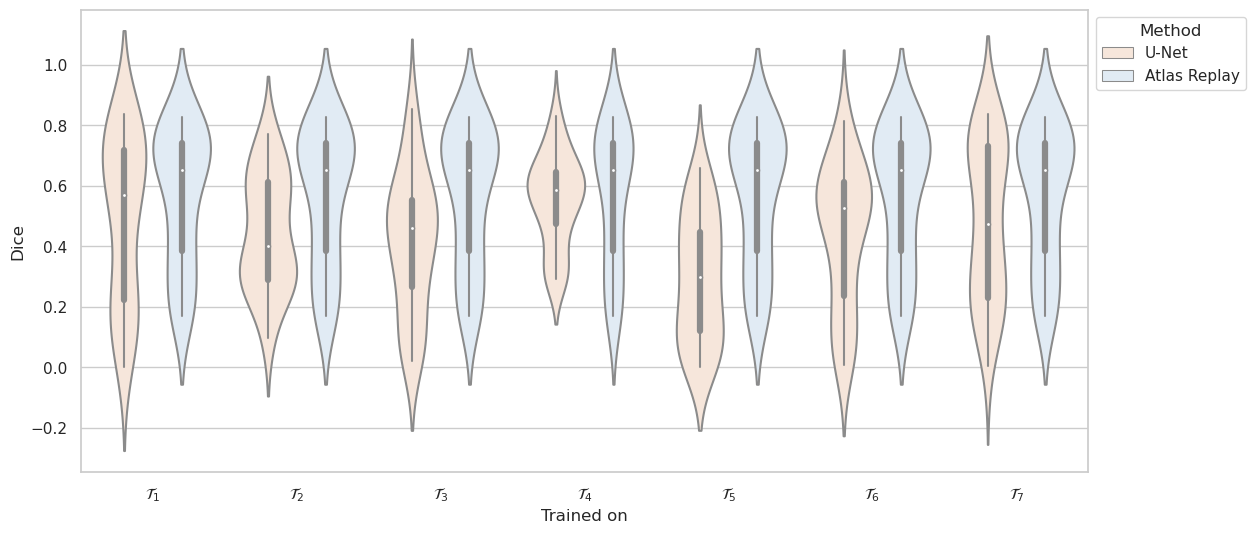

In [7]:
plt.figure(figsize=(13, 6))

# Plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x="Trained on", y="Dice", data=data, hue='Method', palette=['#fae5d6', '#deebf7'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('/home/aranem_locale/Desktop/MICCAI_2023/MICCAI_2023_evaluation/plots/violin_simple_unet_vxm.pdf', bbox_inches='tight')

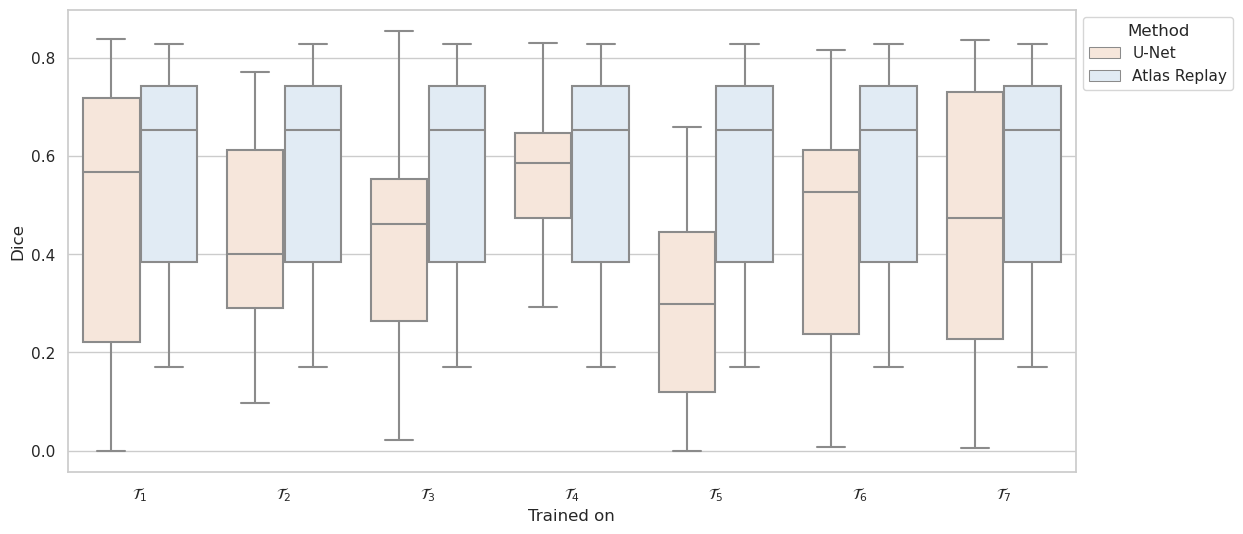

In [8]:
plt.figure(figsize=(13, 6))

# Plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x="Trained on", y="Dice", data=data, hue='Method', palette=['#fae5d6', '#deebf7'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('/home/aranem_locale/Desktop/MICCAI_2023/MICCAI_2023_evaluation/plots/boxplot_simple_unet_vxm.pdf', bbox_inches='tight')

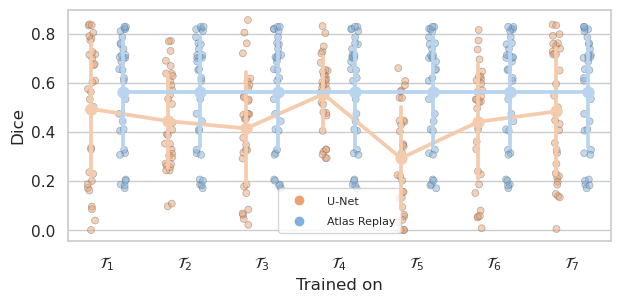

In [9]:
plt.figure(figsize=(7, 3))

# Plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.pointplot(data=data, x="Trained on", y="Dice", errorbar="sd", hue='Method', palette=[adjust_lightness('#fae5d6', 0.9), adjust_lightness('#deebf7', 0.9)], dodge=0.41)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.stripplot(x="Trained on", y="Dice", data=data, hue='Method', palette=[adjust_lightness('#fae5d6', 0.75), adjust_lightness('#deebf7', 0.75)], dodge=0.15, alpha=0.5, linewidth=0.5)#, jitter=False)
plt.legend(loc='lower center', title='')
plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('/home/aranem_locale/Desktop/MICCAI_2023/MICCAI_2023_evaluation/plots/scatter_simple_unet_vxm.pdf', bbox_inches='tight')